In [2]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from run_user_process_train import user_process_train
import json
import os
# 評価（例）
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder

# データ読み込み
df=pd.read_csv("../data/processed/discrete_30_wine_quality.csv")
X=df.drop(["color"],axis=1)
y=df.loc[:,"color"]  


#繰り返し回数
N=5
split_portion=0.9
target_fold_index=[1,2,3,4,5,6,7,8,9,10]
balanced_accuracy_list=[]
#初期設定数値
L=30
dimension_number=7
epsilon=15
low_threshold=10
max_interval_len=5
epsilons=[5,7,10,12,15,17,20]
# Foldとsplit再現
skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
for epsilon in epsilons:
    sum_balanced_accuracy=0
    for fold_index, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        x_train_full = X.loc[train_idx].reset_index(drop=True)
        y_train_full = y.loc[train_idx].reset_index(drop=True)
        x_test = X.loc[test_idx].reset_index(drop=True)
        y_test = y.loc[test_idx].reset_index(drop=True)

        x_train, x_feature, y_train, y_feature = train_test_split(
            x_train_full, y_train_full, train_size=split_portion, random_state=42
        )
        for noise_num in range(N):
            # モデル読み込み
            model_dir = os.path.abspath(os.path.join("..", "models", f"epsilon{epsilon:.2f}",f"Fold{fold_index}",f"{noise_num}"))
            
            # 選択された属性の保存
            selected_columns_path = os.path.join(model_dir, "selected_columns.csv")
            #modelの保存
            model_name = "random_forest_model"
            model_path = os.path.join(model_dir, f"{model_name}.joblib")
            
            
            classfier = joblib.load(model_path)
            selected_columns=pd.read_csv(selected_columns_path).squeeze().values
            file_path = os.path.join( "..", "data", "external", "domain",
                    f"epsilon{epsilon:.2f}", f"Fold{fold_index}", f"{noise_num}",
                    f"ADR_domain_T_{low_threshold}_L_{max_interval_len}.json"
                )
            with open(file_path, 'r', encoding='utf-8') as f:
                    decided_domain_dict = json.load(f)
            # テストデータをノイズ無しでユーザ側処理
            x_test_ADR_RR, y_test_RR = user_process_train(x_test, y_test, "no_noise", decided_domain_dict , selected_columns)

            # 予測
            y_pred = classfier.predict(x_test_ADR_RR)

            #print("Fold",fold_index,"number",noise_num,"Test accuracy:", balanced_accuracy_score(y_test_RR, y_pred))
            sum_balanced_accuracy+=balanced_accuracy_score(y_test_RR, y_pred)
    balanced_accuracy=sum_balanced_accuracy/(N*fold_index)
    balanced_accuracy_list.append(balanced_accuracy)   
print(balanced_accuracy_list)

[0.627673219276135, 0.5707766307848527, 0.7125827452609704, 0.8096655753689369, 0.806519692131396, 0.8346332530436645, 0.8790557321724844]


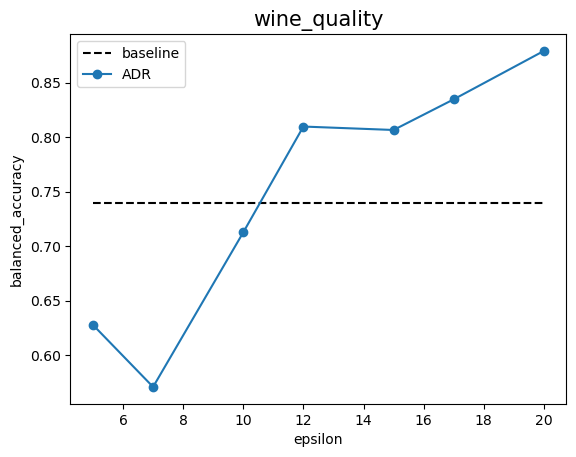

In [3]:
import matplotlib.pyplot as plt
epsilons=[5,7,10,12,15,17,20]
y=balanced_accuracy_list
x=epsilons

plt.hlines(0.7397732424551047,5,20,linestyles="--",colors="black",label="baseline")
plt.plot(x,y,marker='o',label="ADR")
plt.title('wine_quality',fontsize=15)
plt.xlabel('epsilon',fontsize=10)
plt.ylabel('balanced_accuracy',fontsize=10)
plt.legend()